In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import datetime as dt
import time
import awkward as ak
import uproot
import polars as pl
from tqdm import tqdm
from glob import glob
from scipy import stats as st
from scipy import signal
import numba as nb

import mplhep
mplhep.style.use(mplhep.style.ROOT)
plt.rcParams.update({'font.size': 23,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                     'figure.figsize': [14,6]
                     })


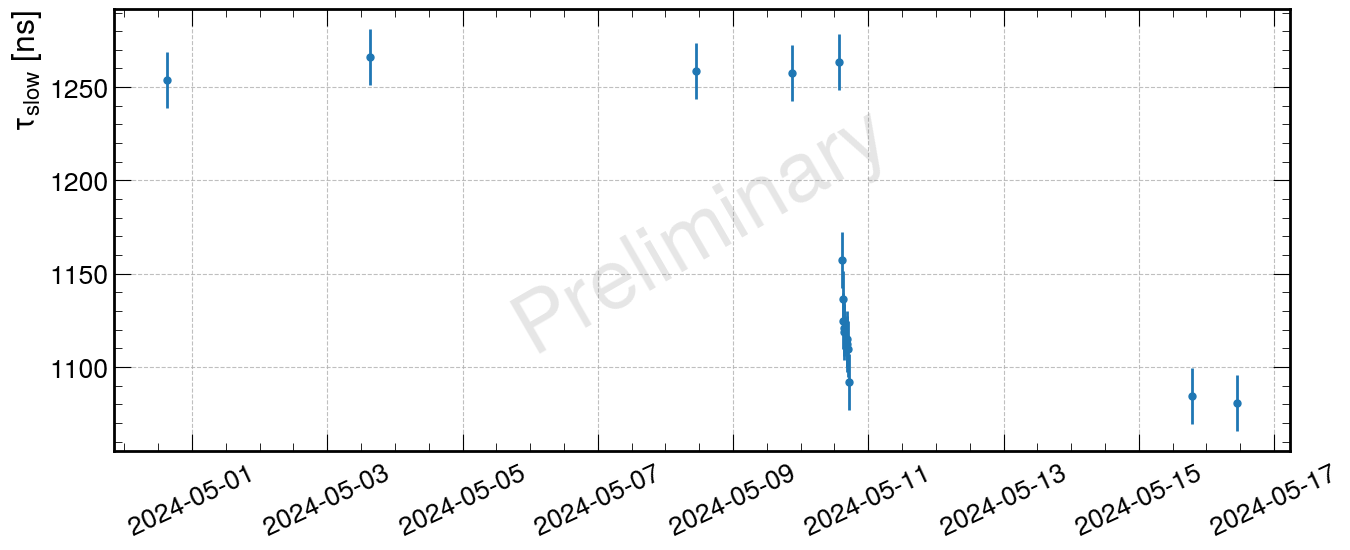

In [2]:
files = sorted(glob("./run0*/convolution_output.txt"))

dtp = ["time", "A_f", "tau_f", "tau_s"]

dict_Efield = {
25171:0.,
25474:0.,
26078:0.,
26084:0.,
26116:0.,
26141:0.,
26145:20.,
26147:40.,
26149:60.,
26152:80.,
26154:100.,
26161:120.,
26163:140.,
26165:160.,
26167:180.,
26163:180.,
26165:180.,
26167:180.,
26254:180.,
26265:180.,
}
df = pl.DataFrame([])
for i, file in enumerate(files):
    dfi = pl.read_csv(file, has_header=False, separator=" ", new_columns=dtp)
    for run, ef in dict_Efield.items():
        if f'run0{run}' in file:
            dfi = dfi.with_columns(
                time = pl.col('time')*16e-9,
                run = run,
                Efield = ef
            )
    dfi = dfi.drop('run').insert_column(0, dfi.get_column('run'))
    if df.is_empty():
        df = dfi
    else:
        df = df.vstack(dfi)
    

    
def preliminary(ax, x=0.5, y=0.5):
    ax.text(x, y, 'Preliminary', transform=ax.transAxes,
            fontsize=60, color='gray', alpha=0.2,
            ha='center', va='center', rotation=30)

plt.subplots_adjust(bottom=0.2)
plt.xticks(rotation=25)
ax = plt.gca()
xfmt = mdate.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(xfmt)
    
dates=[dt.datetime.fromtimestamp(ts) for ts in df['time']]
plt.errorbar(dates, df["tau_s"], yerr=15, fmt='.', linewidth=2, markersize=10)
plt.ylabel(r'$\tau_{slow}$ [ns]')
preliminary(ax)

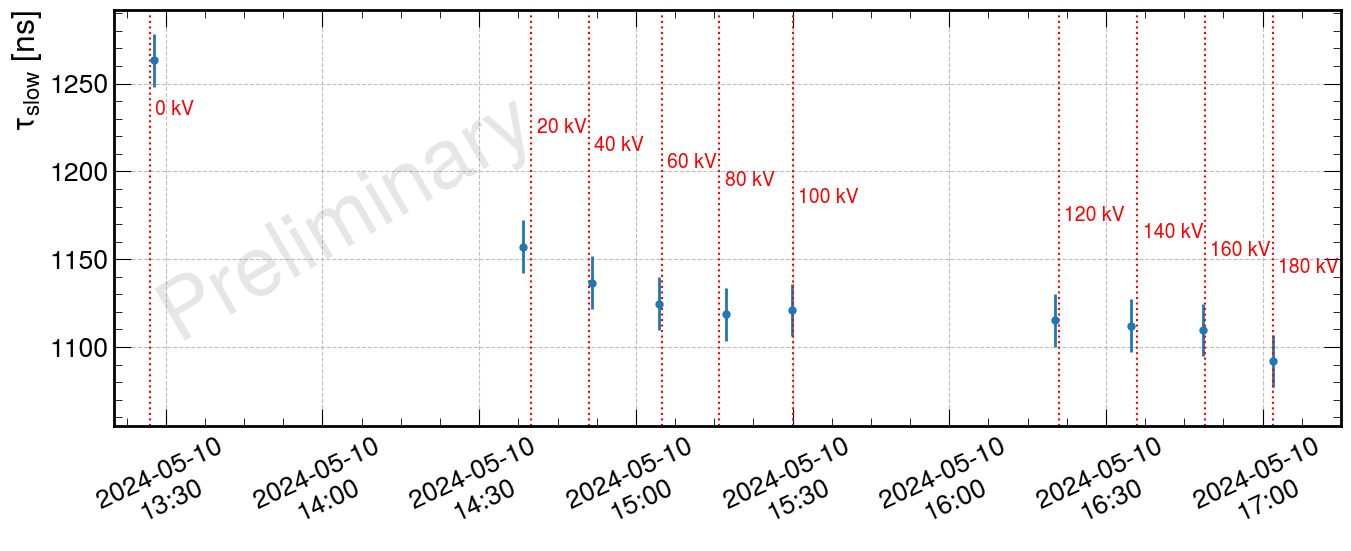

In [ ]:

plt.subplots_adjust(bottom=0.2)
plt.xticks(rotation=25)
ax = plt.gca()
xfmt = mdate.DateFormatter('%Y-%m-%d\n%H:%M')
ax.xaxis.set_major_formatter(xfmt)
timeflags ={
"2024-05-10T13:27": "0 kV",
"2024-05-10T14:40": "20 kV",
"2024-05-10T14:51": "40 kV",
"2024-05-10T15:05": "60 kV",
"2024-05-10T15:16": "80 kV",
"2024-05-10T15:30": "100 kV",
"2024-05-10T16:21": "120 kV",
"2024-05-10T16:36": "140 kV",
"2024-05-10T16:49": "160 kV",
"2024-05-10T17:02": "180 kV",
}


vlines = [ dt.datetime.fromisoformat(d) for d in timeflags.keys() ]
    
dates=[dt.datetime.fromtimestamp(ts) for ts in df['time']]
plt.errorbar(dates, df["tau_s"], yerr=15, fmt='.', linewidth=2, markersize=10)
plt.ylabel(r'$\tau_{slow}$ [ns]')
# plt.errorbar(dates, 1-data["A_f"], yerr=0.002, fmt='+', )
# plt.ylabel(r'Slow component fraction')
plt.xlim(dt.datetime.fromisoformat('2024-05-10T13:20'), dt.datetime.fromisoformat('2024-05-10T17:15'))
for i, (line, tag) in enumerate(zip(vlines, timeflags.values())):
    plt.axvline(line, linestyle=':', color='r')
    plt.text(line+dt.timedelta(minutes=1), y=ax.get_ylim()[1]-60-i*10,s=tag, fontsize=14, color='r')
    # plt.text(line+dt.timedelta(minutes=1), y=ax.get_ylim()[1]-0.01-i*0.005,s=tag, fontsize=14, color='r')
ax.get_ylim()
preliminary(ax,0.19)

In [4]:
dfa = df.group_by("Efield").agg(
    pl.all().mean(),
)
dfa

Efield,run,time,A_f,tau_f,tau_s
f64,f64,f64,f64,f64,f64
0.0,25797.2,1.7150e9,0.2206,34.624,1259.898
20.0,26145.0,1.7153e9,0.252,34.67,1157.16
40.0,26147.0,1.7153e9,0.261,34.73,1136.55
60.0,26149.0,1.7153e9,0.267,35.01,1124.73
80.0,26152.0,1.7153e9,0.27,34.82,1118.6
100.0,26154.0,1.7153e9,0.27,34.98,1121.08
120.0,26161.0,1.7154e9,0.271,35.23,1115.27
180.0,26202.8,1.7155e9,0.2732,34.904,1095.842


Nitrogen concentration: 1.53 +/- 0.14


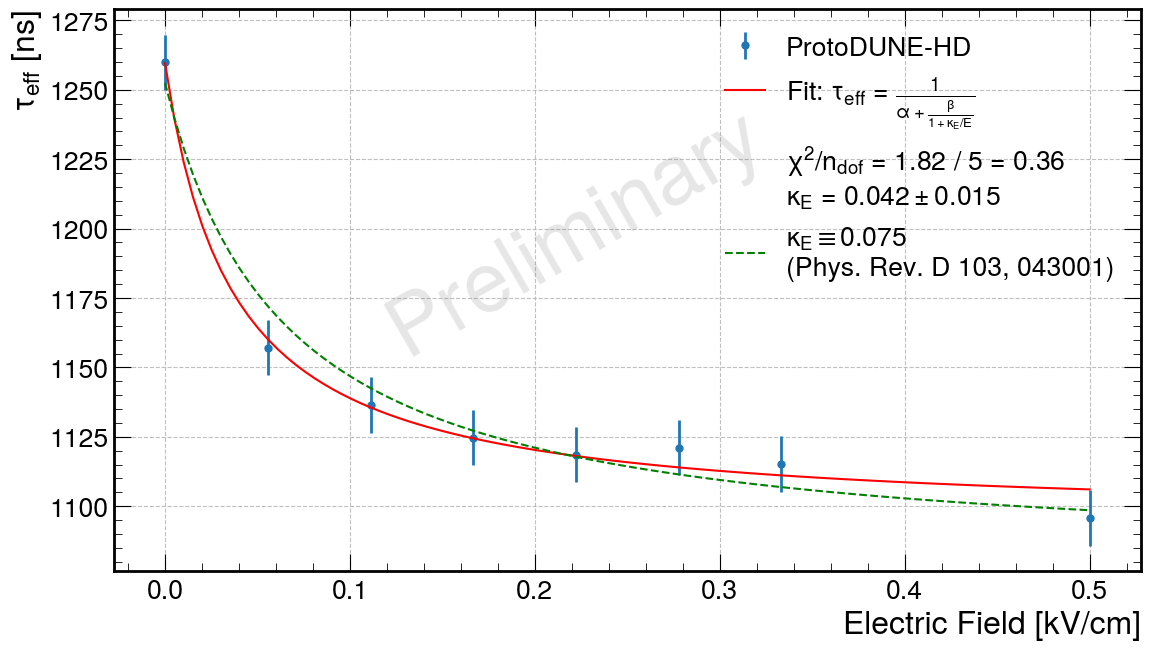

In [78]:
from iminuit import Minuit, cost
from iminuit.util import describe

def model_n2(df:pl.DataFrame):
    tau_eff_0 = df.filter(pl.col('Efield')==0)['tau_s'].to_numpy()[0]*1e-3
    er_tau_eff_0 = 0.02
    tau_slow = 1.600
    kq0 = 0.11
    erkq0 = 0.01
    kq = 1/tau_eff_0 - 1/tau_slow
    erkq = kq*(er_tau_eff_0/tau_eff_0)
    n2 = kq/kq0
    ern2 = n2*np.sqrt((erkq/kq)**2 + (erkq0/kq0)**2 )
    return kq, n2, ern2
def model_efield(e, alpha, beta, k):
    with np.errstate(divide='ignore', invalid='ignore'):
        tau = np.divide(1,alpha + beta/(1+k/e), out=np.ones_like(e)/alpha, where=e!=0)
    return tau

# kq = 0.11+-0.01 1/ppm 1/us, kq = 0.11 * N2c
kn2, n2c, ern2c = model_n2(dfa)
print(f"Nitrogen concentration: {n2c:.2f} +/- {ern2c:.2f}")

ef = dfa['Efield']/360
tau_s = dfa['tau_s']

errors = np.ones_like(len(ef))*10.

def dofit(ef, tau_s, errors, fix=False):
    c = cost.LeastSquares(ef, tau_s, errors, model_efield)

    tau_eff_0 = df.filter(pl.col('Efield')==0)['tau_s'].to_numpy()[0]
    alpha = 1/tau_eff_0
    beta = 0.00015
    k = 0.075

    m = Minuit(c,alpha=alpha, beta=beta, k=k)

    m.fixed['k'] = fix

    m.migrad()
    m.migrad()
    m.migrad()

    pars = describe(model_efield)[1:]
    vals = [m.values[p] for p in pars]
    return vals, m
vals, m = dofit(ef, tau_s, errors, False)
ef_fake = np.linspace(ef[0], ef[-1],100)

plt.figure(figsize=(12,7))
plt.errorbar(ef, tau_s, errors, fmt='.', linewidth=2, markersize=10, label='ProtoDUNE-HD')
plt.ylabel(r'$\tau_{eff}$ [ns]')
plt.xlabel(r'Electric Field [kV/cm]')
plt.xlim(-10/360,190/360)

preliminary(plt.gca(),0.45,0.6)

plt.plot(ef_fake,model_efield(ef_fake,*vals),color='r',zorder=100, label=r'Fit: $\tau_{eff}$ = $\frac{1}{\alpha + \frac{\beta}{1+\kappa_E/E}}$')
fit_info = [
    f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.2f} / {m.ndof:.0f} = {m.fmin.reduced_chi2:.2f}",
]
# for p, v, e in zip(m.parameters, m.values, m.errors):
fit_info.append(f"$\\kappa_E$ = ${m.params['k'].value:.3f} \\pm {m.params['k'].error:.3f}$")
plt.plot([],[], ' ', label='\n'.join(fit_info))

vals_ettore, me = dofit(ef, tau_s, errors, True)
plt.plot(ef_fake,model_efield(ef_fake,*vals_ettore), '--g',zorder=200, label=r"$\kappa_E \equiv 0.075$" "\n" "(Phys. Rev. D 103, 043001)")

#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [3,0,1,2]

#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.savefig('tau_vs_efield_fit.png', dpi=200)



In [6]:
1/m.params['alpha'].value

1259.5875875084184